## Table of Contents

### 1. Data Loading and Preprocessing
> #### 1.1 Load the Data
> #### 1.2 Define custom dataset
> #### 1.3 Data Exploration
### 2. Lane Segmentation using FCN
> #### 2.1 Define model architecture
> #### 2.2 Train the model
> #### 2.3 Calculate IoU score
---

### 1. Data Loading and Preprocessing

#### 1.1 Load the Data

In [1]:
# Upload data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Image_Segmentation/camVidzip.zip

Archive:  /content/drive/MyDrive/Image_Segmentation/camVidzip.zip
  inflating: data/CamVid/test/0001TP_008550.png  
  inflating: data/CamVid/test/0001TP_008580.png  
  inflating: data/CamVid/test/0001TP_008610.png  
  inflating: data/CamVid/test/0001TP_008640.png  
  inflating: data/CamVid/test/0001TP_008670.png  
  inflating: data/CamVid/test/0001TP_008700.png  
  inflating: data/CamVid/test/0001TP_008730.png  
  inflating: data/CamVid/test/0001TP_008760.png  
  inflating: data/CamVid/test/0001TP_008790.png  
  inflating: data/CamVid/test/0001TP_008820.png  
  inflating: data/CamVid/test/0001TP_008850.png  
  inflating: data/CamVid/test/0001TP_008880.png  
  inflating: data/CamVid/test/0001TP_008910.png  
  inflating: data/CamVid/test/0001TP_008940.png  
  inflating: data/CamVid/test/0001TP_008970.png  
  inflating: data/CamVid/test/0001TP_009000.png  
  inflating: data/CamVid/test/0001TP_009030.png  
  inflating: data/CamVid/test/0001TP_009060.png  
  inflating: data/CamVid/test/0001

In [3]:
# import libraries and modules
%matplotlib inline

import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from random import random

# import pytorch related modules
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Resize

from torch.nn import Sequential
from torch.nn import Conv2d, ReLU, Sigmoid, BatchNorm2d, Dropout

from torchvision.models.segmentation import fcn_resnet101, deeplabv3_resnet101
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

In [4]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed);

In [5]:
x_train_dir = '/content/data/CamVid/train'
y_train_dir = '/content/data/CamVid/trainannot'

x_val_dir = '/content/data/CamVid/val'
y_val_dir = '/content/data/CamVid/valannot'

x_test_dir = '/content/data/CamVid/test'
y_test_dir = '/content/data/CamVid/testannot'

#### 1.2 Define custom dataset

In [6]:
# define custom dataset class
class CamVidDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, transforms=None, training_type=None):
        # get all image names
        self.image_names = os.listdir(images_dir)

        # set training type, transforms
        self.training_type = training_type
        self.transforms = transforms

        # get image and target paths
        self.images_paths = []
        self.masks_paths = []
        for image_name in self.image_names:
            self.images_paths.append(os.path.join(images_dir, image_name))
            if self.training_type=="train" or self.training_type=="val":
                self.masks_paths.append(os.path.join(masks_dir, image_name.split('.')[0] + '.png'))

    def __getitem__(self, i):

        if self.training_type=="train" or self.training_type=="val":
            # read data
            image = Image.open(self.images_paths[i])
            mask = Image.open(self.masks_paths[i])

            # preprocess mask
            mask = np.array(mask)
            mask = (mask == 3)
            mask = Image.fromarray(mask)

            # apply transforms
            image = self.transforms(image)
            mask = self.transforms(mask)

            return image, mask

        else:
            # read data
            image = Image.open(self.images_fps[i])

            # apply transforms
            image = self.transforms(image)

            return image

    def __len__(self):
        return len(self.image_names)

#### 1.3 Data Exploration

In [7]:
train_transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])

In [8]:
# Lets look at data we have
dataset = CamVidDataset(x_train_dir, y_train_dir, transforms=train_transforms, training_type='train')

image, gt_mask = dataset[0]

In [9]:
image.shape, gt_mask.shape

(torch.Size([3, 224, 224]), torch.Size([1, 224, 224]))

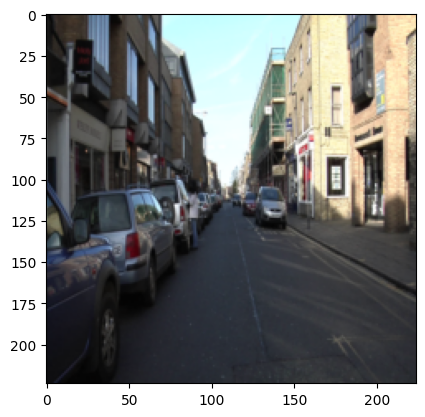

In [10]:
plt.imshow(np.transpose(image, (1, 2, 0)))

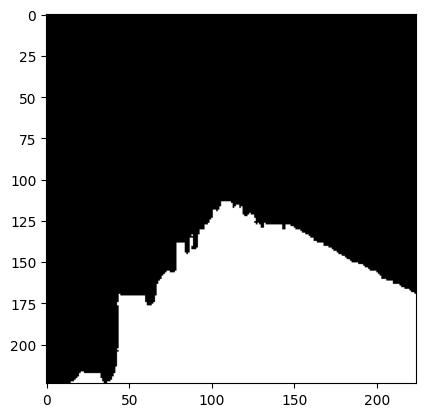

In [11]:
plt.imshow(gt_mask.squeeze(), cmap='gray')

In [12]:
# create transform
train_transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])
# create instance of custom dataset
train_dataset = CamVidDataset(
    x_train_dir,
    y_train_dir,
    transforms=train_transforms,
    training_type='train'
)
# create dataloader
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=4
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [13]:
for batch_x, batch_y in train_loader:
    break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [14]:
batch_x.shape, batch_y.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 1, 224, 224]))

### 2. Lane Segmentation using FCN

#### 2.1 Define model architecture

In [15]:
# define model
model = fcn_resnet101(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 208M/208M [00:01<00:00, 144MB/s]


In [16]:
# print model
model

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [17]:
# freeze model parameters
for parameters in model.parameters():
    parameters.requires_grad = False

In [18]:
model.classifier = Sequential(
    Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    ReLU(),
    Dropout(p=0.1, inplace=False),
    Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1)), # Last few layers are changed we have just 1 class
    Sigmoid()
)

In [19]:
# check for one iteration of loop
for batch_x, batch_y in train_loader:
    break

In [20]:
# check model on one image
model.eval()
output = model(batch_x[1].view(1, 3, 224, 224))['out'].detach().numpy()

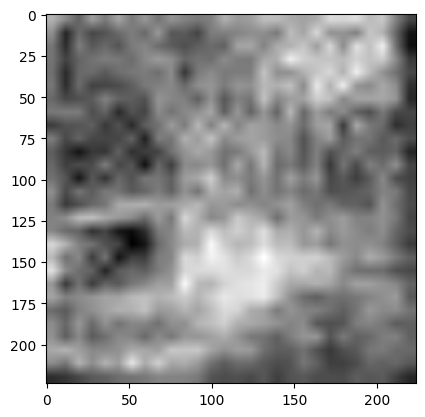

In [21]:
# print output
plt.imshow(output.squeeze(), cmap='gray')

#### 2.2 Train the model

In [22]:
# transfer model to GPU
model = model.to("cuda")

In [23]:
# define optimization and loss function
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=1e-3)

In [24]:
# set model to train
model.train()

# train model
for epoch in range(5):

    # initialize variables
    epoch_loss = cnt = 0

    # loop through the data
    for batch_x, batch_y in train_loader:
        # get batch images and targets and transfer them to GPU
        batch_x = batch_x.to("cuda").float()
        batch_y = batch_y.to("cuda").float()

        # clear gradients
        optimizer.zero_grad()

        # pass images to model
        outputs = model(batch_x)

        # get loss
        loss = criterion(outputs['out'], batch_y)

        # do a backward pass
        loss.backward()

        # update gradients
        optimizer.step()

        # sum loss and get count
        epoch_loss += loss.item()
        cnt += 1

    # take average loss for all batches
    epoch_loss /= cnt

    # print loss
    print("Training loss for epoch {} is {} ".format(epoch + 1, epoch_loss))

Training loss for epoch 1 is 0.20392872717069543 
Training loss for epoch 2 is 0.12505399856878363 
Training loss for epoch 3 is 0.1035862056457478 
Training loss for epoch 4 is 0.08724771861148917 
Training loss for epoch 5 is 0.07629369782364886 


#### 2.3 Calculate IoU score

In [25]:
# get sample data
image = Image.open('/content/data/CamVid/train/0006R0_f00930.png')
gt_mask = Image.open('/content/data/CamVid/trainannot/0006R0_f00930.png')

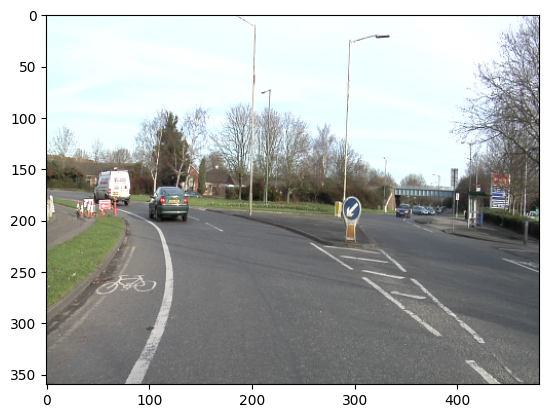

In [26]:
plt.imshow(image)

In [27]:
# preprocess mask
gt_mask = np.array(gt_mask)
gt_mask = (gt_mask == 3)
gt_mask = Image.fromarray(gt_mask)

# apply data augmentation
transform = Compose([
            Resize((224, 224)),
            ToTensor()
            ])

image = transform(image)

gt_mask = transform(gt_mask)

In [28]:
model.eval()
output = model(image.view(1, 3, 224, 224).to("cuda"))['out'].cpu().detach().numpy()

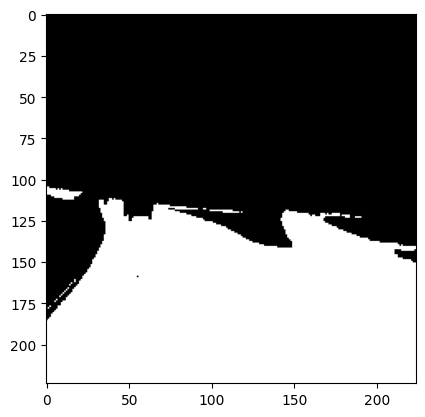

In [29]:
plt.imshow(gt_mask.squeeze(), cmap='gray')

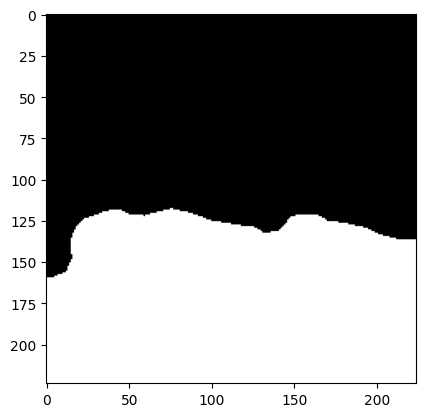

In [30]:
plt.imshow((output.squeeze() > 0.5).astype(int), cmap='gray')

In [31]:
# convert predicted mask to flattened numpy array
mask = (output.squeeze() > 0.5).astype(int)
pred = mask.ravel().copy()

# convert ground truth mask to flattened numpy array
gt_mask = gt_mask.cpu().detach().numpy()
target = gt_mask.ravel().copy().astype(int)

# get class indices for Lane
pred_inds = pred == 1
target_inds = target == 1

# calculate intersection
intersection = pred_inds[target_inds].sum()

# calculate union
union = pred_inds.sum() + target_inds.sum() - intersection

# get IoU score
iou = (float(intersection) / float(max(union, 1)))
iou

0.9110530657135001

-------------------------------------------------------------

### 2. Lane Segmentation using DeepLabv3

#### 3.1 Define model architecture

In [ ]:
model = deeplabv3_resnet101(pretrained=True)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


In [ ]:
for parameters in model.parameters():
    parameters.requires_grad = False

In [ ]:
model.classifier = DeepLabHead(in_channels=2048, num_classes=1)

In [ ]:
# check for one iteration of loop
for batch_x, batch_y in train_loader:
    break

In [ ]:
# check model on one image
model.eval()
output = model(batch_x[1].view(1, 3, 224, 224))['out'].detach().numpy()

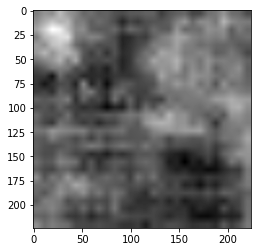

In [ ]:
# print output
plt.imshow(output.squeeze(), cmap='gray')

#### 3.2 Train the model

In [ ]:
# transfer model to GPU
model = model.to("cuda")

In [ ]:
# define optimization and loss function
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=1e-3)

In [ ]:
# set model to train
model.train()

# train model
for epoch in range(5):

    # initialize variables
    epoch_loss = cnt = 0

    # loop through the data
    for batch_x, batch_y in train_loader:
        # get batch images and targets and transfer them to GPU
        batch_x = batch_x.to("cuda").float()
        batch_y = batch_y.to("cuda").float()

        # clear gradients
        optimizer.zero_grad()

        # pass images to model
        outputs = model(batch_x)

        # get loss
        loss = criterion(outputs['out'], batch_y)

        # do a backward pass
        loss.backward()

        # update gradients
        optimizer.step()

        # sum loss and get count
        epoch_loss += loss.item()
        cnt += 1

    # take average loss for all batches
    epoch_loss /= cnt

    # print loss
    print("Training loss for epoch {} is {} ".format(epoch + 1, epoch_loss))

Training loss for epoch 1 is 0.16160690298546915 
Training loss for epoch 2 is 0.08582162241572919 
Training loss for epoch 3 is 0.06951171840014665 
Training loss for epoch 4 is 0.05915875619520312 
Training loss for epoch 5 is 0.05214554978453595 


#### 3.3 Calculate IoU score

In [ ]:
# get sample data
image = Image.open('/content/data/CamVid/train/0006R0_f00930.png')
gt_mask = Image.open('/content/data/CamVid/trainannot/0006R0_f00930.png')

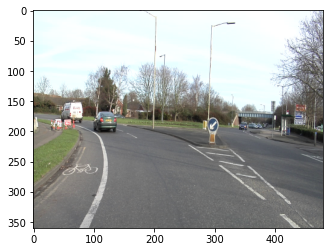

In [ ]:
plt.imshow(image)

In [ ]:
# preprocess mask
gt_mask = np.array(gt_mask)
gt_mask = (gt_mask == 3)
gt_mask = Image.fromarray(gt_mask)

# apply data augmentation
transform = Compose([
            Resize((224, 224)),
            ToTensor()
            ])

image = transform(image)

gt_mask = transform(gt_mask)

In [ ]:
model.eval()
output = model(image.view(1, 3, 224, 224).to("cuda"))['out'].cpu().detach().numpy()

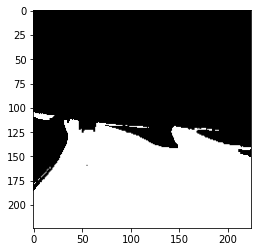

In [ ]:
plt.imshow(gt_mask.squeeze(), cmap='gray')

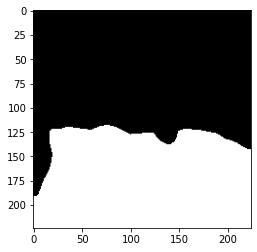

In [ ]:
plt.imshow((output.squeeze() > 0.5).astype(int), cmap='gray')

In [ ]:
# convert predicted mask to flattened numpy array
mask = (output.squeeze() > 0.5).astype(int)
pred = mask.ravel().copy()

# convert ground truth mask to flattened numpy array
gt_mask = gt_mask.cpu().detach().numpy()
target = gt_mask.ravel().copy().astype(int)

# get class indices for Lane
pred_inds = pred == 1
target_inds = target == 1

# calculate intersection
intersection = pred_inds[target_inds].sum()

# calculate union
union = pred_inds.sum() + target_inds.sum() - intersection

# get IoU score
iou = (float(intersection) / float(max(union, 1)))
iou